In [1]:
import numpy as np 
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
from shapely.geometry.polygon import Polygon
from shapely import wkt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn import metrics

In [2]:
streets = gpd.GeoDataFrame.from_file('geo_export_ccfbdf2d-83b4-4827-a495-e26464c3c50b.shp')

streets = gpd.GeoDataFrame.from_file('geo_export_ccfbdf2d-83b4-4827-a495-e26464c3c50b.shp')
traffic = pd.read_csv('traffic_matched.csv')
traffic = traffic.dropna(subset = ['geometry'])
traffic['geometry'] = traffic['geometry'].astype(str).apply(wkt.loads)
traffic = pd.melt(traffic, id_vars=['Date', 'geometry', 'streetID'], value_vars=list(traffic.columns[7:31]),
        var_name='time', value_name='traffic')
traffic = gpd.GeoDataFrame(traffic, geometry = 'geometry')

C:\Users\Andy\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (31,32,33,34,36,37,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
traffic['area'] = traffic['geometry'].area
traffic = traffic[traffic['area']<2e-5]

In [4]:
traffic['start_time'] = traffic['time'].str[:2]
traffic['start_time'] = traffic['start_time'].str.replace(':', '')
traffic['start_time'] = pd.to_numeric(traffic['start_time'])
traffic['start_time'] = np.where(traffic['time'].str[-2:] == 'PM', traffic['start_time']+12, traffic['start_time'])
traffic['start_time'] = np.where(traffic['time']=='11:00-12:00AM', 23, traffic['start_time'])
traffic['start_time'] = np.where(traffic['time']=='11:00-12:00PM', 11, traffic['start_time'])

In [5]:
traffic['Date_f'] = traffic['Date'].str[-4:] + '-' + traffic['Date'].str[:2] + '-' + traffic['Date'].str[-7:-5]   #.sort_values().unique()
traffic['Date_f'] = pd.to_datetime(traffic['Date_f'])
traffic

,Date,geometry,streetID,time,traffic,area,start_time,Date_f
0,01/09/2012,"POLYGON ((-74.07980 40.62882, -74.07981 40.628...",576.0,12:00-1:00 AM,20.0,7.116706e-07,12,2012-01-09
1,01/10/2012,"POLYGON ((-74.07980 40.62882, -74.07981 40.628...",576.0,12:00-1:00 AM,21.0,7.116706e-07,12,2012-01-10
2,01/11/2012,"POLYGON ((-74.07980 40.62882, -74.07981 40.628...",576.0,12:00-1:00 AM,27.0,7.116706e-07,12,2012-01-11
3,01/12/2012,"POLYGON ((-74.07980 40.62882, -74.07981 40.628...",576.0,12:00-1:00 AM,22.0,7.116706e-07,12,2012-01-12
4,01/13/2012,"POLYGON ((-74.07980 40.62882, -74.07981 40.628...",576.0,12:00-1:00 AM,31.0,7.116706e-07,12,2012-01-13
...,...,...,...,...,...,...,...,...
330667,03/25/2017,"POLYGON ((-73.93188 40.85429, -73.93187 40.854...",2281.0,11:00-12:00AM,120.0,2.577393e-07,23,2017-03-25
330668,03/26/2017,"POLYGON ((-73.94480 40.69812, -73.94480 40.698...",1843.0,11:00-12:00AM,92.0,5.300767e-08,23,2017-03-26
330669,03/26/2017,"POLYGON ((-73.94480 40.69812, -73.94480 40.698...",1843.0,11:00-12:00AM,83.0,5.300767e-08,23,2017-03-26
330670,03/26/2017,"POLYGON ((-73.93188 40.85429, -73.93187 40.854...",2281.0,11:00-12:00AM,86.0,2.577393e-07,23,2017-03-26


In [6]:
traffic['end_time'] = traffic['time'].str[-7:-2]
traffic['end_time'] = traffic['end_time'].str.replace(':', '')
traffic['end_time'] = traffic['end_time'].str.replace('-', '')
traffic['end_time'] = pd.to_numeric(traffic['end_time'])
traffic['end_time'] = np.where(traffic['time'].str[-2:] == 'PM', traffic['end_time']+12, traffic['end_time'])
traffic['end_time'] = np.where(traffic['time']=='11:00-12:00AM', 0, traffic['end_time'])
traffic['end_time'] = np.where(traffic['time']=='11:00-12:00PM', 12, traffic['end_time'])

In [7]:
collisions = pd.read_csv('collisions_matched.tsv', sep = "\t")
collisions['hour'] = collisions['CRASH TIME'].str[:2]
collisions['hour'] = pd.to_numeric(collisions['hour'].str.replace(':', ''))

C:\Users\Andy\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
tc = pd.merge(traffic, collisions, how = 'left', left_on = ['streetID', 'start_time', 'Date'], right_on = ['streetID', 'hour', 'CRASH DATE'])
tc

,Date,geometry,streetID,time,traffic,area,start_time,Date_f,end_time,collision_id,...,int2,zip1,zip2,ll1,ll2,lat1,long1,lat2,long2,hour
0,01/09/2012,"POLYGON ((-74.07980 40.62882, -74.07981 40.628...",576.0,12:00-1:00 AM,20.0,7.116706e-07,12,2012-01-09,100,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01/10/2012,"POLYGON ((-74.07980 40.62882, -74.07981 40.628...",576.0,12:00-1:00 AM,21.0,7.116706e-07,12,2012-01-10,100,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01/11/2012,"POLYGON ((-74.07980 40.62882, -74.07981 40.628...",576.0,12:00-1:00 AM,27.0,7.116706e-07,12,2012-01-11,100,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01/12/2012,"POLYGON ((-74.07980 40.62882, -74.07981 40.628...",576.0,12:00-1:00 AM,22.0,7.116706e-07,12,2012-01-12,100,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01/13/2012,"POLYGON ((-74.07980 40.62882, -74.07981 40.628...",576.0,12:00-1:00 AM,31.0,7.116706e-07,12,2012-01-13,100,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329042,03/25/2017,"POLYGON ((-73.93188 40.85429, -73.93187 40.854...",2281.0,11:00-12:00AM,120.0,2.577393e-07,23,2017-03-25,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329043,03/26/2017,"POLYGON ((-73.94480 40.69812, -73.94480 40.698...",1843.0,11:00-12:00AM,92.0,5.300767e-08,23,2017-03-26,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329044,03/26/2017,"POLYGON ((-73.94480 40.69812, -73.94480 40.698...",1843.0,11:00-12:00AM,83.0,5.300767e-08,23,2017-03-26,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329045,03/26/2017,"POLYGON ((-73.93188 40.85429, -73.93187 40.854...",2281.0,11:00-12:00AM,86.0,2.577393e-07,23,2017-03-26,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
traffic_risk = tc.groupby(by = ['streetID', 'Date', 'start_time'],as_index = False).agg({'traffic':['sum'],
                                                                                         'collision_id':['count'],
                                                                                        'geometry':['first']})
traffic_risk.columns = ['streetID', 'Date', 'start_time', 'traffic', 'collisions', 'geometry']
traffic_risk['risk_rate'] = (traffic_risk['collisions'] / traffic_risk['traffic']) * 1000 # for easier computation
traffic_risk['risk_ind'] = np.where(traffic_risk['collisions'] > 0, 1, 0)
traffic_risk

,streetID,Date,start_time,traffic,collisions,geometry,risk_rate,risk_ind
0,0.0,09/30/2012,1,464.0,0,"POLYGON ((-73.94411 40.78388, -73.94412 40.783...",0.0,0
1,0.0,09/30/2012,2,452.0,0,"POLYGON ((-73.94411 40.78388, -73.94412 40.783...",0.0,0
2,0.0,09/30/2012,3,399.0,0,"POLYGON ((-73.94411 40.78388, -73.94412 40.783...",0.0,0
3,0.0,09/30/2012,4,678.0,0,"POLYGON ((-73.94411 40.78388, -73.94412 40.783...",0.0,0
4,0.0,09/30/2012,5,379.0,0,"POLYGON ((-73.94411 40.78388, -73.94412 40.783...",0.0,0
...,...,...,...,...,...,...,...,...
191395,2442.0,11/08/2015,20,406.0,0,"POLYGON ((-73.84312 40.82559, -73.84312 40.825...",0.0,0
191396,2442.0,11/08/2015,21,312.0,0,"POLYGON ((-73.84312 40.82559, -73.84312 40.825...",0.0,0
191397,2442.0,11/08/2015,22,249.0,0,"POLYGON ((-73.84312 40.82559, -73.84312 40.825...",0.0,0
191398,2442.0,11/08/2015,23,183.0,0,"POLYGON ((-73.84312 40.82559, -73.84312 40.825...",0.0,0


Barely any observations have collision risk. We will need to oversample and reframe as a classification problem.

In [10]:
traffic_risk['risk_rate'][traffic_risk['risk_rate'] > 0].shape[0] / traffic_risk['risk_rate'].shape[0]

0.0013061650992685476

In [11]:
# Join traffic easing
bikes = pd.read_csv('bike_lanes_matched.csv')
bikes = bikes.dropna(subset = ['streetID'])
bikes = bikes.drop_duplicates(subset = ['streetID'])
bikes = bikes[['streetID', 'lanecount']]

speed_bumps = pd.read_csv('speed_bumps_matched.csv')
speed_bumps = speed_bumps.dropna(subset = ['streetID'])
speed_bumps = speed_bumps.drop_duplicates(subset = ['streetID'])
speed_bumps = speed_bumps[['streetID', 'new_humps']]

speed_limits = pd.read_csv('speed_limits_matched.csv')
speed_limits = speed_limits.dropna(subset = ['streetID'])
speed_limits = speed_limits.drop_duplicates(subset = ['streetID'])
speed_limits = speed_limits[['streetID', 'postvz_sl']]

C:\Users\Andy\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
traffic_risk = pd.merge(traffic_risk, bikes, on = 'streetID', how = 'left')
traffic_risk = pd.merge(traffic_risk, speed_bumps, on = 'streetID', how = 'left')
traffic_risk = pd.merge(traffic_risk, speed_limits, on = 'streetID', how = 'left')
# bike lanes lane_count
traffic_risk['lanecount'] = np.where(traffic_risk['lanecount'] >= 0, traffic_risk['lanecount'], 0)
traffic_risk['new_humps'] = np.where(traffic_risk['new_humps'] >= 0, traffic_risk['new_humps'], 0)
traffic_risk['postvz_sl'] = np.where(traffic_risk['postvz_sl'] >= 0, traffic_risk['postvz_sl'], 0)

In [13]:
traffic_risk

,streetID,Date,start_time,traffic,collisions,geometry,risk_rate,risk_ind,lanecount,new_humps,postvz_sl
0,0.0,09/30/2012,1,464.0,0,"POLYGON ((-73.94411 40.78388, -73.94412 40.783...",0.0,0,1.0,0.0,25.0
1,0.0,09/30/2012,2,452.0,0,"POLYGON ((-73.94411 40.78388, -73.94412 40.783...",0.0,0,1.0,0.0,25.0
2,0.0,09/30/2012,3,399.0,0,"POLYGON ((-73.94411 40.78388, -73.94412 40.783...",0.0,0,1.0,0.0,25.0
3,0.0,09/30/2012,4,678.0,0,"POLYGON ((-73.94411 40.78388, -73.94412 40.783...",0.0,0,1.0,0.0,25.0
4,0.0,09/30/2012,5,379.0,0,"POLYGON ((-73.94411 40.78388, -73.94412 40.783...",0.0,0,1.0,0.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...
191395,2442.0,11/08/2015,20,406.0,0,"POLYGON ((-73.84312 40.82559, -73.84312 40.825...",0.0,0,0.0,1.0,25.0
191396,2442.0,11/08/2015,21,312.0,0,"POLYGON ((-73.84312 40.82559, -73.84312 40.825...",0.0,0,0.0,1.0,25.0
191397,2442.0,11/08/2015,22,249.0,0,"POLYGON ((-73.84312 40.82559, -73.84312 40.825...",0.0,0,0.0,1.0,25.0
191398,2442.0,11/08/2015,23,183.0,0,"POLYGON ((-73.84312 40.82559, -73.84312 40.825...",0.0,0,0.0,1.0,25.0


In [14]:
traffic_risk = gpd.GeoDataFrame(traffic_risk, geometry = 'geometry')
traffic_risk[['minx', 'miny', 'maxx', 'maxy']] = traffic_risk['geometry'].bounds
traffic_risk['month'] = pd.to_datetime(traffic_risk['Date']).dt.month
traffic_risk['year'] = pd.to_datetime(traffic_risk['Date']).dt.year
basedate = pd.Timestamp('2000-01-01')
traffic_risk['days_since_00'] = (pd.to_datetime(traffic_risk['Date']) - basedate).dt.days

In [15]:
traffic_risk_no_na = traffic_risk.dropna(how = 'any')

In [16]:
# Train regression
train_lr_b = traffic_risk_no_na[traffic_risk_no_na['year'] < 2016]
test_lr_b = traffic_risk_no_na[traffic_risk_no_na['year'] >= 2016]

X_train_lr_b = train_lr_b[['start_time', 'month', 'year', 'days_since_00', 'lanecount', 'new_humps', 'postvz_sl']]
y_train_lr_b = train_lr_b['risk_ind']

X_test_lr_b = test_lr_b[['start_time', 'month', 'year', 'days_since_00', 'lanecount', 'new_humps', 'postvz_sl']]
y_test_lr_b = test_lr_b['risk_ind']

Xsm_train_lr_b = sm.add_constant(X_train_lr_b)
Xsm_test_lr_b = sm.add_constant(X_test_lr_b)

model_base = sm.Logit(y_train_lr_b, Xsm_train_lr_b)
result_base = model_base.fit()
result_base.summary()

         Current function value: 0.009280
         Iterations: 35


C:\Users\Andy\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               risk_ind   No. Observations:               157041
Model:                          Logit   Df Residuals:                   157033
Method:                           MLE   Df Model:                            7
Date:                Fri, 09 Dec 2022   Pseudo R-squ.:                 0.03686
Time:                        18:18:34   Log-Likelihood:                -1457.3
converged:                      False   LL-Null:                       -1513.0
Covariance Type:            nonrobust   LLR p-value:                 4.423e-21
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            57.5659   6089.581      0.009      0.992   -1.19e+04     1.2e+04
start_time        0.0226      0.010      2.176      0.030       0.002       0.043
month             0.2768      0.257      1.077      0.281      -0.227       0.781
year             -0.0319      3.045     -0.010      0.992      -5.999       5.936
days_since_00    -0.0005      0.008     -0.062      0.950      -0.017       0.016
lanecount         0.2738      0.087      3.155      0.002       0.104       0.444
new_humps        -0.0543      0.114     -0.476      0.634      -0.278       0.169
postvz_sl        -0.0147      0.021     -0.689      0.491      -0.057       0.027
=================================================================================
"""

In [17]:
def oversample(data, ycol, min_prop = 0.1):
    m_class = data[data[ycol] == 1]
    needed_rows = int((min_prop*data.shape[0])/(1 - min_prop))
    added_rows = needed_rows - m_class.shape[0]
    new_rows = m_class.sample(n=added_rows, replace = True)
    data = pd.concat([data, new_rows], axis = 0, ignore_index = True)
    return data

In [18]:
# Oversample
traffic_risk_no_na_os = oversample(traffic_risk, 'risk_ind')

In [19]:
train_lr_os = traffic_risk_no_na_os[traffic_risk_no_na_os['year'] < 2016]
test_lr_os = traffic_risk_no_na[traffic_risk_no_na['year'] >= 2016]

X_train_lr_os = train_lr_os[['start_time', 'month', 'year', 'days_since_00', 'lanecount', 'new_humps', 'postvz_sl']]
y_train_lr_os = train_lr_os['risk_ind']

X_test_lr_os = test_lr_os[['start_time', 'month', 'year', 'days_since_00', 'lanecount', 'new_humps', 'postvz_sl']]
y_test_lr_os = test_lr_os['risk_ind']

Xsm_train_lr_os = sm.add_constant(X_train_lr_os)
Xsm_test_lr_os = sm.add_constant(X_test_lr_os)

model_os = sm.Logit(y_train_lr_os, Xsm_train_lr_os)
result_os = model_os.fit()
result_os.summary()

         Current function value: 0.295154
         Iterations: 35


C:\Users\Andy\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               risk_ind   No. Observations:               177592
Model:                          Logit   Df Residuals:                   177584
Method:                           MLE   Df Model:                            7
Date:                Fri, 09 Dec 2022   Pseudo R-squ.:                 0.05056
Time:                        18:18:35   Log-Likelihood:                -52417.
converged:                      False   LL-Null:                       -55208.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4.285e+04    739.539     57.945      0.000    4.14e+04    4.43e+04
start_time        0.0256      0.001     20.294      0.000       0.023       0.028
month            -1.4982      0.031    -48.311      0.000      -1.559      -1.437
year            -21.4270      0.370    -57.947      0.000     -22.152     -20.702
days_since_00     0.0582      0.001     57.327      0.000       0.056       0.060
lanecount         0.3133      0.010     30.099      0.000       0.293       0.334
new_humps        -0.0309      0.013     -2.343      0.019      -0.057      -0.005
postvz_sl        -0.0262      0.003     -9.488      0.000      -0.032      -0.021
=================================================================================
"""

In [20]:
# train xgboost
train_xgb_b = traffic_risk[traffic_risk['year'] < 2016]
test_xgb_b = traffic_risk[traffic_risk['year'] >= 2016]

X_train_xgb_b = train_xgb_b[['start_time', 'month', 'year', 'days_since_00', 'lanecount', 'new_humps', 'postvz_sl']] # add traffic easing
y_train_xgb_b = train_xgb_b['risk_ind']

X_test_xgb_b = test_xgb_b[['start_time', 'month', 'year', 'days_since_00', 'lanecount', 'new_humps', 'postvz_sl']] # add traffic easing
y_test_xgb_b = test_xgb_b['risk_ind']

In [21]:
xgb_model = xgb.XGBClassifier()

In [22]:
%%time
parameters = {'nthread':[-1],
              'objective':['binary:logistic'],
              'learning_rate': [0.01, 0.025, 0.05, 0.75, 0.1, 0.2, 0.35],
              'max_depth': [3, 4, 5, 6],
              'n_estimators': [50, 100, 250, 500, 1000]
             }


clf = GridSearchCV(xgb_model, parameters, n_jobs=-1, 
                   cv=4, 
                   verbose=2, refit=True)

clf.fit(X_train_xgb_b, y_train_xgb_b)
print(clf.best_score_)

Fitting 4 folds for each of 140 candidates, totalling 560 fits


C:\Users\Andy\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:39:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9987776123107471
Wall time: 21min 6s


In [23]:
# retrain with all dates and best params

full_xgb_base = xgb.XGBRegressor(**clf.best_params_)
full_xgb_base.fit(X_train_xgb_b, y_train_xgb_b)

[18:39:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=12, nthread=-1, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [24]:
# oversample
traffic_risk_os = oversample(traffic_risk, 'risk_ind')

In [25]:
train_os = traffic_risk_os[traffic_risk_os['year'] < 2016]
test_os = traffic_risk[traffic_risk['year'] >= 2016]

X_train_xgb_os = train_os[['start_time', 'month', 'year', 'days_since_00', 'lanecount', 'new_humps', 'postvz_sl']] # add traffic easing
y_train_xgb_os = train_os['risk_ind']

X_test_xgb_os = test_os[['start_time', 'month', 'year', 'days_since_00', 'lanecount', 'new_humps', 'postvz_sl']] # add traffic easing
y_test_xgb_os = test_os['risk_ind']

In [26]:
xgb_model = xgb.XGBClassifier()

In [27]:
%%time
parameters = {'nthread':[-1],
              'objective':['binary:logistic'],
              'learning_rate': [0.01, 0.025, 0.05, 0.75, 0.1, 0.2, 0.35],
              'max_depth': [3, 4, 5, 6],
              'n_estimators': [50, 100, 250, 500, 1000]
             }


clf_os = GridSearchCV(xgb_model, parameters, n_jobs=-1, 
                   cv=4, 
                   verbose=2, refit=True)

clf_os.fit(X_train_xgb_os, y_train_xgb_os)
print(clf_os.best_score_)

Fitting 4 folds for each of 140 candidates, totalling 560 fits


C:\Users\Andy\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:05:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9820982373995453
Wall time: 25min 53s


In [28]:
full_xgb_os = xgb.XGBRegressor(**clf_os.best_params_)
full_xgb_os.fit(X_train_xgb_os, y_train_xgb_os)

[19:05:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.75, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, nthread=-1, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [29]:
# Compare all AUC
fpr_logit, tpr_logit, t_logit = metrics.roc_curve(y_test_lr_b, result_base.predict(Xsm_test_lr_b))
fpr_logit_os, tpr_logit_os, t_logit_os = metrics.roc_curve(y_test_lr_os, result_os.predict(Xsm_test_lr_os))
fpr_xgb, tpr_xgb, t_xgb = metrics.roc_curve(y_test_xgb_b, full_xgb_base.predict(X_test_xgb_b))
fpr_xgb_os, tpr_xgb_os, t_xgb_os = metrics.roc_curve(y_test_xgb_os, full_xgb_os.predict(X_test_xgb_os))

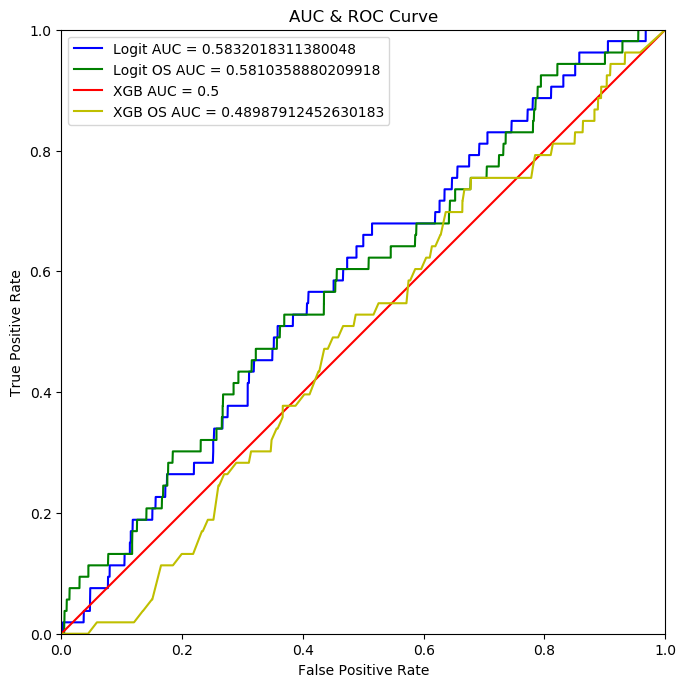

In [30]:
plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")

plt.plot(fpr_logit, tpr_logit, 'b', label = f'Logit AUC = {metrics.roc_auc_score(y_test_lr_b, result_base.predict(Xsm_test_lr_b))}')
plt.plot(fpr_logit_os, tpr_logit_os, 'g', label = f'Logit OS AUC = {metrics.roc_auc_score(y_test_lr_os, result_os.predict(Xsm_test_lr_os))}')
plt.plot(fpr_xgb, tpr_xgb, 'r', label=f'XGB AUC = {metrics.roc_auc_score(y_test_xgb_b, full_xgb_base.predict(X_test_xgb_b))}')
plt.plot(fpr_xgb_os, tpr_xgb_os, 'y', label=f'XGB OS AUC = {metrics.roc_auc_score(y_test_xgb_os, full_xgb_os.predict(X_test_xgb_os))}')

#plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [33]:

# Show imputed predictions with charts from other notebook and map of a few sample dates
dates = pd.DataFrame({'Date': pd.date_range(start='1/1/2012', end='1/01/2018')})
dates['key'] = 1
hours = pd.DataFrame({'start_time': pd.Series(range(24))})
hours['key'] = 1
streets = traffic_risk[["streetID", "lanecount", "new_humps", "postvz_sl"]].drop_duplicates(keep='first')
streets['key'] = 1
pred_df = pd.merge(dates, hours, how = 'outer', on = 'key') 
pred_df = pd.merge(pred_df, streets, how = 'outer', on = 'key')
pred_df['month'] = pd.to_datetime(pred_df['Date']).dt.month
pred_df['year'] = pd.to_datetime(pred_df['Date']).dt.year
basedate = pd.Timestamp('2000-01-01')
pred_df['days_since_00'] = (pd.to_datetime(pred_df['Date']) - basedate).dt.days
pred_df['pred_log_base'] = result_base.predict(sm.add_constant(pred_df[['start_time', 'month', 'year', 'days_since_00', 'lanecount', 'new_humps', 'postvz_sl']]))
pred_df['pred_log_os'] = result_os.predict(sm.add_constant(pred_df[['start_time', 'month', 'year', 'days_since_00', 'lanecount', 'new_humps', 'postvz_sl']]))
pred_df['pred_xgb_base'] = full_xgb_base.predict(pred_df[['start_time', 'month', 'year', 'days_since_00', 'lanecount', 'new_humps', 'postvz_sl']])
pred_df['pred_xgb_os'] = full_xgb_os.predict(pred_df[['start_time', 'month', 'year', 'days_since_00', 'lanecount', 'new_humps', 'postvz_sl']])
pred_df


,Date,key,start_time,streetID,lanecount,new_humps,postvz_sl,month,year,days_since_00,pred_log_base,pred_log_os,pred_xgb_base,pred_xgb_os
0,2012-01-01,1,0,0.0,1.0,0.0,25.0,1,2012,4383,0.000178,0.005265,0.303244,0.000000e+00
1,2012-01-01,1,0,1.0,1.0,3.0,25.0,1,2012,4383,0.000151,0.004801,0.303244,0.000000e+00
2,2012-01-01,1,0,2.0,1.0,1.0,25.0,1,2012,4383,0.000169,0.005105,0.303244,0.000000e+00
3,2012-01-01,1,0,3.0,1.0,0.0,25.0,1,2012,4383,0.000178,0.005265,0.303244,0.000000e+00
4,2012-01-01,1,0,4.0,1.0,0.0,25.0,1,2012,4383,0.000178,0.005265,0.303244,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48631963,2018-01-01,1,23,2431.0,0.0,0.0,30.0,1,2018,6575,0.000056,0.002195,0.303244,2.453585e-12
48631964,2018-01-01,1,23,2434.0,0.0,0.0,25.0,1,2018,6575,0.000060,0.002502,0.303244,9.433787e-10
48631965,2018-01-01,1,23,2440.0,0.0,1.0,25.0,1,2018,6575,0.000057,0.002426,0.303244,1.101961e-11
48631966,2018-01-01,1,23,2441.0,2.0,0.0,25.0,1,2018,6575,0.000104,0.004671,0.303244,9.143999e-06


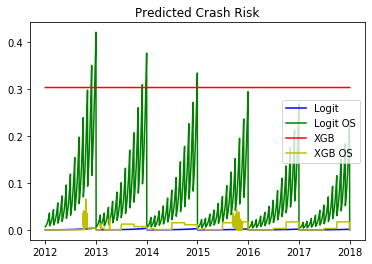

In [40]:
# join preds and original, group by date and time
# visualize predictions over time vs actual
pred_agg = pred_df[['Date', 'pred_log_base', 'pred_log_os', 'pred_xgb_base',
                   'pred_xgb_os']].groupby(by = 'Date', as_index = False).mean()
pred_agg.columns = ['Date', 'pred_log_base', 'pred_log_os', 'pred_xgb_base','pred_xgb_os']
plt.plot(pred_agg['Date'], pred_agg['pred_log_base'],color = 'b', label = 'Logit')
plt.plot(pred_agg['Date'], pred_agg['pred_log_os'],color = 'g', label = 'Logit OS')
plt.plot(pred_agg['Date'], pred_agg['pred_xgb_base'],color = 'r', label = 'XGB')
plt.plot(pred_agg['Date'], pred_agg['pred_xgb_os'],color = 'y', label = 'XGB OS')
plt.title('Predicted Crash Risk')
plt.legend()
plt.show()